In [1]:
import torch
import numpy as np
import sys

import matplotlib.pyplot as plt

sys.path.insert(0,'../pulp-frontnet/PyTorch')
sys.path.insert(0,'../adversarial_frontnet/')
from Frontnet.Frontnet import FrontnetModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from util import load_dataset, load_model
model_path = '../pulp-frontnet/PyTorch/Models/Frontnet160x32.pt'
model_config = '160x32'
dataset_path = '../pulp-frontnet/PyTorch/Data/160x96StrangersTestset.pickle'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(path=model_path, device=device, config=model_config)
model.eval()
dataset = load_dataset(path=dataset_path, batch_size=32, shuffle=False, drop_last=True, num_workers=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

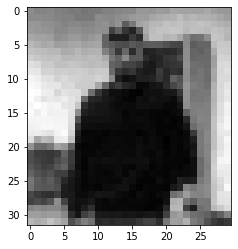

In [100]:
custom_patch = np.load("custom_patch.npy")
custom_patch = torch.from_numpy(custom_patch)
plt.imshow(custom_patch, cmap='gray')

In [94]:
from patch_placement import place_patch

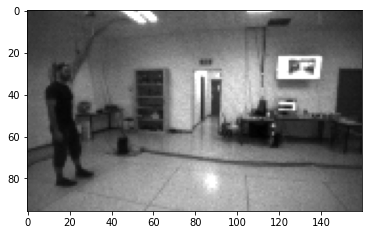

In [6]:
img = dataset.dataset.__getitem__(0)[0]
plt.imshow(img[0], cmap='gray')
# plt.savefig(path+'ori_image.jpg', dpi=200)

In [7]:
transformation_matrix = [[[0.4, 0, -0.80], [0, 0.4, -0.6]]]
transformation_matrix = torch.tensor(transformation_matrix).float()

In [ ]:
exposure = 200
again = 4
dgain = 1.0

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


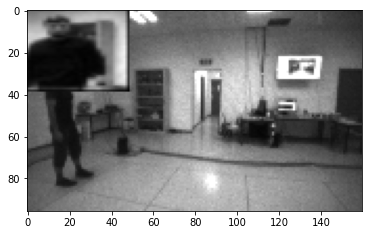

In [8]:
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

In [9]:
import os
path = "eval_custom_patch/eval_translation/"
os.makedirs(path, exist_ok=True)

In [10]:
camera_intrinsics = np.load("camera_intrinsic.npy")
camera_extrinsics = np.load("full_translate.npy")

In [11]:
print(camera_intrinsics, camera_extrinsics)

[[ 89.52641296   0.          61.36280235]
 [  0.          66.52072144 134.92632966]
 [  0.           0.           1.        ]] [[ 0.18706529 -0.97502846  0.11969143 -0.19717897]
 [-0.66391182 -0.21528806 -0.71615094 -0.93262298]
 [ 0.72403568  0.05450242 -0.68760586  0.34973731]]


In [57]:
prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)

In [76]:
prediciton_ori.detach().clone()

tensor([2.2261, 1.5141, 0.4459, 0.5643])

In [119]:
target = prediciton_ori.detach().clone()
target[0] = 1.0
print(target)

tensor([1.0000, 1.5141, 0.4459, 0.5643])


In [121]:
target = prediciton_ori.detach().clone()
target[1] = -2
print(target)

tensor([ 2.2261, -2.0000,  0.4459,  0.5643])


In [111]:
target = prediciton_ori.detach().clone()
target[2] = 0.5
print(target)

tensor([2.2261, 1.5141, 0.5000, 0.5643])


In [201]:
all_outputs = []
count = 0

untargeted_losses = np.zeros((120,170))

x_min_losses = np.zeros((120, 170))
x_max_losses = np.zeros((120, 170))

y_min_losses = np.zeros((120, 170))
y_max_losses = np.zeros((120, 170))

z_min_losses = np.zeros((120, 170))
z_max_losses = np.zeros((120, 170))

prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)
target_x_min = prediciton_ori.detach().clone()
target_x_min[0] = 1.0

target_x_max = prediciton_ori.detach().clone()
target_x_max[0] = 3.6

target_y_min = prediciton_ori.detach().clone()
target_y_min[1] = -2.0

target_y_max = prediciton_ori.detach().clone()
target_y_max[1] = 2.0


target_z_min = prediciton_ori.detach().clone()
target_z_min[2] = -0.5

target_z_max = prediciton_ori.detach().clone()
target_z_max[2] = 0.5

# target = prediciton_ori.detach().clone()
# target[0] = 1.0

for tx in range(-80, 90):
    for ty in range(-60, 60):
        transformation_matrix = [[[0.4, 0, tx/100], [0, 0.4, ty/100]]]
        transformation_matrix = torch.tensor(transformation_matrix).float()
        mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)


        prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

        loss = torch.dist(prediciton_ori, prediction_mod, p=2)
        # loss = -torch.dist(target, prediction_mod, p=2)
        untargeted_losses[ty+60][tx+80] = loss.detach().numpy()

        # x_max_losses[ty+60][tx+80] = -torch.dist(target_x_max, prediction_mod, p=2)
        # x_min_losses[ty+60][tx+80] = -torch.dist(target_x_min, prediction_mod, p=2)

        # y_max_losses[ty+60][tx+80] = -torch.dist(target_y_max, prediction_mod, p=2)
        # y_min_losses[ty+60][tx+80] = -torch.dist(target_y_min, prediction_mod, p=2)

        # z_max_losses[ty+60][tx+80] = -torch.dist(target_z_max, prediction_mod, p=2)
        # z_min_losses[ty+60][tx+80] = -torch.dist(target_z_min, prediction_mod, p=2)

        #all_losses.append([tx/100, ty/100, loss.detach().numpy()])
        
        # output = prediction_mod.detach().squeeze(0).numpy() # np.array([x[0,0].detach().numpy(), y[0,0].detach().numpy(), z[0,0].detach().numpy(), phi[0,0].detach().numpy()])
        # all_outputs.append(output)

        # u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
        # img_x = u/w
        # img_y = v/w

        count += 1

        # plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')
        # plt.scatter(img_x, img_y)
        # plt.savefig(path+f"img_{count}.jpg", dpi=200)
        # plt.close()

# np.save(path+'y_min_l2dist', np.array(all_losses))
# np.save(path+'y_min_outputs', np.array(all_outputs))

# np.save(path+'x_max_l2dist', x_max_losses)
# np.save(path+'x_min_l2dist', x_min_losses)

# np.save(path+'y_max_l2dist', y_max_losses)
# np.save(path+'y_min_l2dist', y_min_losses)

# np.save(path+'z_max_l2dist', z_max_losses)
# np.save(path+'z_min_l2dist', z_min_losses)

np.save(path+'l2_untargeted', untargeted_losses)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [67]:
all_losses.shape

(120, 170)

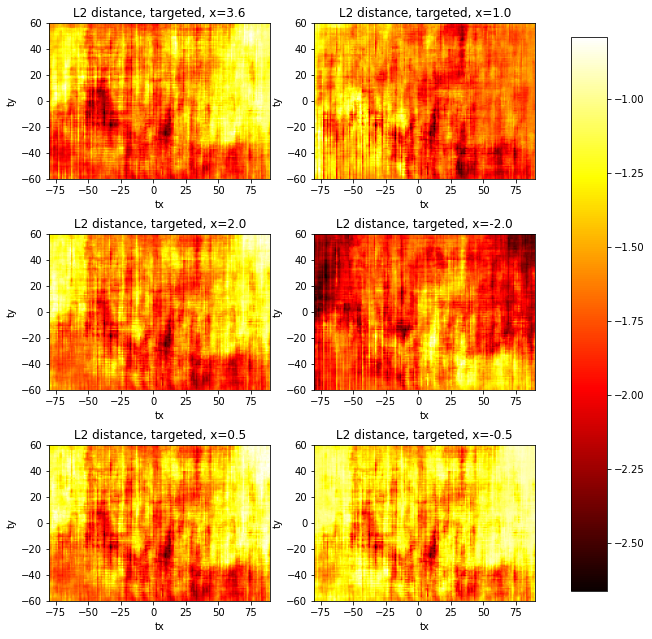

In [149]:
fig, ax = plt.subplots(3, 2, figsize=(10,11))
ax[0][0].imshow(x_max_losses, cmap='hot', extent=[-80,90,60,-60])
ax[0][1].imshow(x_min_losses, cmap='hot', extent=[-80,90,60,-60])
ax[1][0].imshow(y_max_losses, cmap='hot', extent=[-80,90,60,-60])
ax[1][1].imshow(y_min_losses, cmap='hot', extent=[-80,90,60,-60])
ax[2][0].imshow(z_max_losses, cmap='hot', extent=[-80,90,60,-60])
im = ax[2][1].imshow(z_min_losses, cmap='hot', extent=[-80,90,60,-60])


ax[0][0].set_xlabel('tx')
ax[0][1].set_xlabel('tx')
ax[1][0].set_xlabel('tx')
ax[1][1].set_xlabel('tx')
ax[2][0].set_xlabel('tx')
ax[2][1].set_xlabel('tx')
ax[0][0].set_ylabel('ty')
ax[0][1].set_ylabel('ty')
ax[1][0].set_ylabel('ty')
ax[1][1].set_ylabel('ty')
ax[2][0].set_ylabel('ty')
ax[2][1].set_ylabel('ty')

ax[0][0].set_title('L2 distance, targeted, x=3.6')
ax[0][1].set_title('L2 distance, targeted, x=1.0')

ax[1][0].set_title('L2 distance, targeted, y=2.0')
ax[1][1].set_title('L2 distance, targeted, y=-2.0')

ax[2][0].set_title('L2 distance, targeted, z=0.5')
ax[2][1].set_title('L2 distance, targeted, z=-0.5')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig.tight_layout()

plt.savefig(path+'all_targeted.jpg', dpi=200)

In [178]:
np.max(x_max_losses)

-1.1262564659118652

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[2.062441   1.2642801  0.23144595 0.56899464]
[2.2260566  1.5140656  0.44586247 0.5643381 ]
tensor(-0.7901, grad_fn=<NegBackward0>)


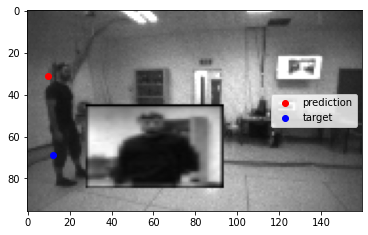

In [197]:
ty_pos, tx_pos = np.unravel_index(np.argmax(z_min_losses), y_max_losses.shape) 

transformation_matrix = [[[0.4, 0, (tx_pos-80)/100], [0, 0.4, (ty_pos-60)/100]]]
transformation_matrix = torch.tensor(transformation_matrix).float()
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='red', label='prediction')

# prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).unsqueeze(0)
output_ori = prediciton_ori.detach().squeeze(0).squeeze(0).numpy()
print(output_ori)
print(-torch.dist(target_z_min, prediction_mod))
# u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output_ori[:3], np.array([1])))
u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((target_z_min.numpy()[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='blue', label='target')
plt.legend(loc='right')
plt.savefig(path+'z_min_max_placed.jpg', dpi=200)

Text(0.5, 1.0, 'l2 distance, targeted, x=3.6')

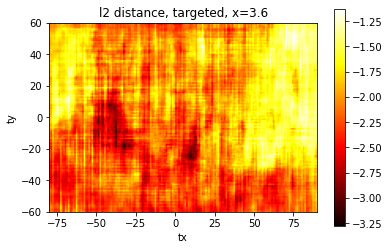

In [125]:
plt.imshow(x_max_losses, cmap='hot', extent=[-80,90,-60,60])
plt.colorbar()
plt.xlabel('tx')
plt.ylabel('ty')
plt.title("l2 distance, targeted, x=3.6")
#plt.savefig(path+"z_max_targeted_loss.jpg", dpi=200)

In [198]:
losses_untargeted = np.load(path+'losses_untargeted.npy')

In [199]:
losses_untargeted.shape

(20400, 3)

In [211]:
torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)

tensor([2.2261, 1.5141, 0.4459, 0.5643], grad_fn=<SqueezeBackward1>)

[ 1.2842147  -0.71196073  0.41247308 -0.08204769]
[2.2260566  1.5140656  0.44586247 0.5643381 ]


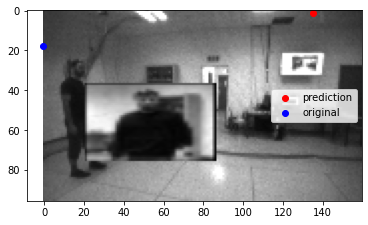

In [215]:
ty_pos, tx_pos = np.unravel_index(np.argmax(untargeted_losses), y_max_losses.shape) 

transformation_matrix = [[[0.4, 0, (tx_pos-80)/100], [0, 0.4, (ty_pos-60)/100]]]
transformation_matrix = torch.tensor(transformation_matrix).float()
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='red', label='prediction')

prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).unsqueeze(0)
output_ori = prediciton_ori.detach().squeeze(0).squeeze(0).numpy()
print(output_ori)
#print(-torch.dist(target_z_min, prediction_mod))
u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output_ori[:3], np.array([1])))
#u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((target_z_min.numpy()[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='blue', label='original')
plt.legend(loc='right')
plt.savefig(path+'untargeted_placed.jpg', dpi=200)

In [46]:
images = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/train_images.npy')

In [47]:
images.shape

(5001, 96, 160)

In [48]:
losses = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/losses_test.npy')

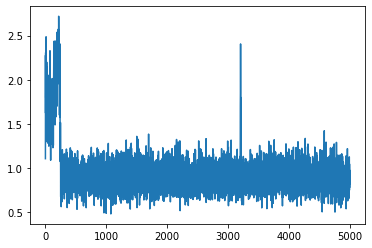

In [50]:
plt.plot(losses)

In [51]:
vectors = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/translation_vectors.npy')

In [60]:
vectors[1200]

array([0.10594101, 1.536905  ], dtype=float32)

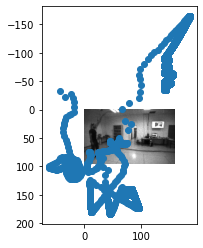

In [62]:
plt.imshow(img[0], cmap='gray')
plt.scatter(([0.80, 0.48] + vectors[i])*100)

[-0.42742062 -0.32001007]
[37.25793839 15.9989934 ]


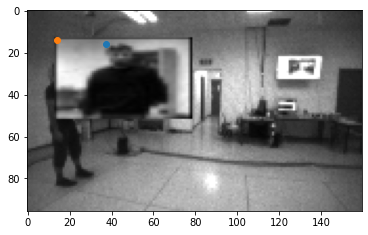

In [93]:
i = 0
plt.imshow(images[i], cmap='gray')
print(vectors[i])
print(([0.8, 0.48] + vectors[i])*100)
img_vec = ([0.8, 0.48] + vectors[i])*100
plt.scatter(img_vec[0], img_vec[1])
plt.scatter(14, 14)

In [95]:
vectors[0]

array([-0.42742062, -0.32001007], dtype=float32)

In [143]:
translation_vector = torch.tensor([0.0, 0.0])
print(translation_vector, translation_vector.shape)

tensor([0., 0.]) torch.Size([2])


In [144]:
rotation_matrix = torch.zeros((2,2))
rotation_matrix[0,0] = 0.5
rotation_matrix[1,1] = 0.5
transformation_matrix = torch.cat([rotation_matrix, translation_vector.unsqueeze(0)]).mT
transformation_matrix = transformation_matrix.unsqueeze(0)

In [145]:
print(transformation_matrix, transformation_matrix.shape)

tensor([[[0.5000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000]]]) torch.Size([1, 2, 3])


In [146]:
zero_image = place_patch(img.unsqueeze(0), custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [132]:
160*0.4

64.0

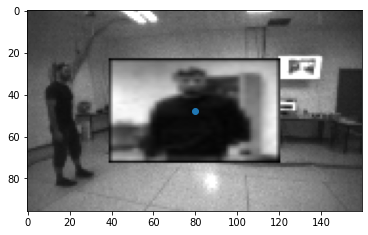

In [147]:
plt.imshow(zero_image[0][0].detach().numpy(), cmap='gray')
plt.scatter(80, 48)

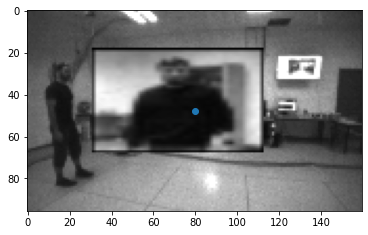

In [149]:
plt.imshow(new_image[0][0].detach().numpy(), cmap='gray')
plt.scatter(80, 48)